In [1]:
import numpy as np
import pickle
import h5py
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import normalize

In [2]:
h5f_train = h5py.File('./Container/train', 'r')
train_features = h5f_train['features_boolean'][:]
train_labels = h5f_train['labels_one_hot'][:]
h5f_train.close()

In [3]:
h5f_valid = h5py.File('./Container/valid_cpl', 'r')
valid_features = h5f_valid['features_cpl'][:]
valid_answer = h5f_valid['features_answer'][:]
answer = np.where(valid_answer - valid_features == 1)[1]
h5f_valid.close()

In [4]:
recipe_num, ingred_num = train_features.shape
_, label_num = train_labels.shape

adj_matrix = np.hstack([np.zeros((recipe_num, recipe_num)), train_features*0.7, train_labels*0.1])
temp_matrix = np.hstack([train_features.T*0.7, np.zeros((ingred_num, ingred_num)), np.zeros((ingred_num, label_num))])
adj_matrix = np.vstack([adj_matrix, temp_matrix])
temp_matrix = np.hstack([train_labels.T*0.1, np.zeros((label_num, ingred_num)), np.zeros((label_num, label_num))])
adj_matrix = np.vstack([adj_matrix, temp_matrix])

In [5]:
adj_matrix = csr_matrix(adj_matrix)

In [6]:
query_num, _ = valid_features.shape
score_matrix = csr_matrix(np.hstack([np.zeros((query_num, recipe_num)), valid_features, np.zeros((query_num, label_num))]))
src_matrix = score_matrix.copy()
#score_matrix = normalize(score_matrix, axis=0, norm='l1')

In [7]:
exist_idx = score_matrix > 0

In [8]:
depth = 10
recipe_threshold = 2000
ingred_threshold = 700
label_threshold = 10

import time
from sklearn.preprocessing import normalize

def topk_values(array, topk):
    temp_mat = np.zeros(len(array))
    topk = min(topk, np.count_nonzero(array > 0))
    temp_mat[np.argpartition(array, -topk)[-topk:]] = 1
    return temp_mat

def topk_per_row(matrix, topk):
    temp_mat = np.apply_along_axis(topk_values, 1, matrix, topk)
    return temp_mat

ingred_topk = 10

macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall10_lst = []
recall_rank_lst = []

for k in range(depth):
    # start node의 누적 점수 * 인접행렬 -> next node에 더해질 값
    src_matrix = np.multiply(score_matrix.toarray(), src_matrix.toarray()) @ adj_matrix
    score_matrix = csr_matrix(score_matrix + src_matrix)
    score_matrix = normalize(score_matrix, axis=1, norm='l1')
    # next_node의 score matrix
    src_matrix = score_matrix.toarray() * (src_matrix>0)
    src_recipe_matrix = topk_per_row(src_matrix[:, :recipe_num], recipe_threshold)
    src_ingred_matrix = topk_per_row(src_matrix[:, recipe_num:recipe_num+ingred_num], ingred_threshold)
    src_label_matrix = topk_per_row(src_matrix[:, recipe_num+ingred_num:], label_threshold)
    src_matrix = csr_matrix(np.hstack([src_recipe_matrix, src_ingred_matrix, src_label_matrix]))
    
    score_matrix_ = score_matrix.copy()
    score_matrix_[exist_idx] = 0
    
    ingred_recs = {}
    ingred_rec_idx_lst = np.argpartition(score_matrix_[:, recipe_num:recipe_num+ingred_num].toarray(), -ingred_topk)[:,-ingred_topk:]
    top_recommends = ingred_rec_idx_lst[:,0].flatten()
        
    MAP = 0
    recall10 = 0
    recall_rank = 0

    for query, ingred_rec_idx in enumerate(ingred_rec_idx_lst):
        ingred_recs[query] = []

        for idx in ingred_rec_idx:
            ingred_recs[query].append((idx, score_matrix_[query, recipe_num + idx]))

        ingred_recs[query].sort(key=lambda x : x[1], reverse=True)

        for j, rec in enumerate(ingred_recs[query]):
            idx, _ = rec
            if answer[query] == idx:
                MAP += 1/(j+1)
                recall10 += 1
                recall_rank += j

    MAP = MAP / len(ingred_rec_idx_lst)
    if recall10 != 0:
        recall_rank_avg = recall_rank / recall10
    else:
        recall_rank_avg = 0
    recall10 = recall10/len(ingred_rec_idx_lst)

    MAP_lst.append(MAP)
    recall10_lst.append(recall10)
    recall_rank_lst.append(recall_rank_avg)

    macro_f1 = f1_score(answer, top_recommends, average='macro')
    micro_f1 = f1_score(answer, top_recommends, average='micro')
    accuracy = accuracy_score(answer, top_recommends)
    macro_f1_lst.append(macro_f1)
    micro_f1_lst.append(micro_f1)
    acc_lst.append(accuracy)
    if k % 1 == 0:
        print("depth:{}\tmacro_f1: {}\tmicro_f1: {}\tacc: {}\tMAP: {}\trecall: {}\trecall_rank: {}".format(k, macro_f1, micro_f1, accuracy, MAP, recall10, recall_rank_avg))
        with open("./recs/Graph_rec_cpl_depth_{}.pickle".format(k), 'wb') as f:
            pickle.dump(ingred_recs, f)
    

depth:0	macro_f1: 0.0	micro_f1: 0.0	acc: 0.0	MAP: 4.247366632687733e-05	recall: 0.00012742099898063202	recall_rank: 2.0
depth:1	macro_f1: 0.00195769104662024	micro_f1: 0.015672782874617736	acc: 0.015672782874617736	MAP: 0.1297780852062201	recall: 0.29268603465851173	recall_rank: 3.108837614279495
depth:2	macro_f1: 0.0019603646008462725	micro_f1: 0.01580020387359837	acc: 0.01580020387359837	MAP: 0.12977014667572806	recall: 0.29268603465851173	recall_rank: 3.110143665650849
depth:3	macro_f1: 0.0005087470266020255	micro_f1: 0.008792048929663608	acc: 0.008792048929663608	MAP: 0.11363364237981984	recall: 0.24821610601427116	recall_rank: 2.9291581108829567
depth:4	macro_f1: 0.0005424626170633158	micro_f1: 0.009174311926605505	acc: 0.009174311926605505	MAP: 0.11366357620180259	recall: 0.2483435270132518	recall_rank: 2.9317598768599282
depth:5	macro_f1: 0.0005046871409997827	micro_f1: 0.010066258919469929	acc: 0.010066258919469929	MAP: 0.10680524205944733	recall: 0.23037716615698267	recall_ran

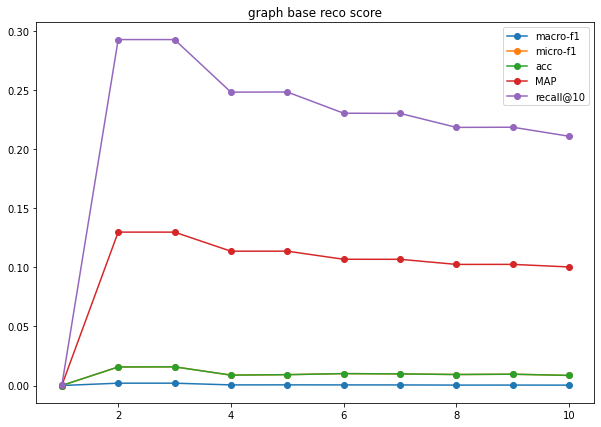

In [10]:
import matplotlib.pyplot as plt

depth_lst = [i for i in range(1, depth+1)]

plt.figure(figsize=(10,7))
plt.plot(depth_lst, macro_f1_lst, 'o-', label='macro-f1')
plt.plot(depth_lst, micro_f1_lst, 'o-', label='micro-f1')
plt.plot(depth_lst, acc_lst, 'o-', label='acc')
plt.plot(depth_lst, MAP_lst, 'o-', label='MAP')
plt.plot(depth_lst, recall10_lst, 'o-', label='recall@10')
plt.title("graph base reco score")
plt.legend()
plt.savefig('./data_analysis/graph_scores.png', dpi=100)
plt.show()

Text(0.5, 1.0, 'graph base reco score')

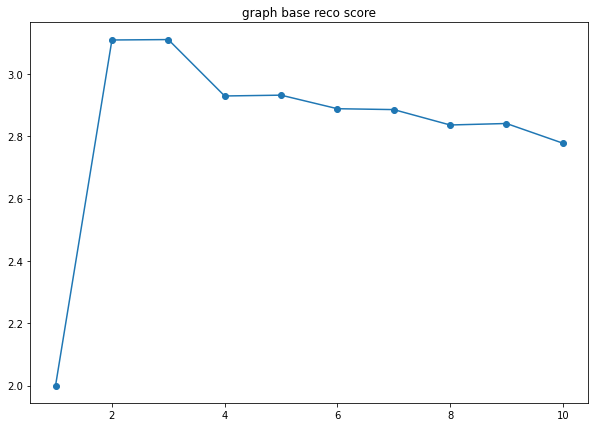

In [11]:
plt.figure(figsize=(10,7))
plt.plot(depth_lst, recall_rank_lst, 'o-', label='recall rank')
plt.title("graph base reco score")

In [12]:
acc_lst

[0.0,
 0.015672782874617736,
 0.01580020387359837,
 0.008792048929663608,
 0.009174311926605505,
 0.010066258919469929,
 0.009811416921508664,
 0.009301732925586137,
 0.0095565749235474,
 0.008537206931702344]